In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randint,uniform,choice
import time

In [2]:
n_pop = 100    # Total population
n_loc = 1     # Total number of locations
n_net = 1      # Total number of networks
n_overlap = 1  # Include the possibility of overlap between work and home locations
n_hospitals = 1 # Set the number of hospitals.

# Initial populations ###########

n  = np.array([0,0,0],dtype=np.int64)
           #  [S,A,P]

##################################

labels      = np.array([0,1,2],dtype=np.int64) # Number of states a person can be in, [S,A,I,R,H] (Not very important, just for bookkeeping)
person_attr = 4           # 4 attributes for a person: state, home, network, current location

### Rates #############

n_states = len(labels)
n_events = 1              # Different events in the model (currently) S->A, A->I, A->R, I->R, I->H, H->R
    
# rate_array = np.zeros((n_states,n_states))

# rate_array[0][1] = 0.45;  # S -> A
# rate_array[0][2] = 0.45;  # S -> I
# rate_array[1][5] = 0.136; # A -> R
# rate_array[2][3] = 0.205; # P -> MI
# rate_array[2][4] = 0.205; # P -> SI
# rate_array[3][5] = 0.1;   # MI -> R
# rate_array[4][6] = 0.25;  # SI -> H
# rate_array[6][5] = 0.1;   # H -> R

rate = np.array([0.06])

Cpars = np.array([1,  1],dtype=np.float64)  # Transmissivity of different individuals. Asymptomatic and symptomatics 
                                     # are just as infectious, hospitalised and quarantined are 10 times less infectious
       # Contact parameters


total_loc_confined_time = 10

days_bw_hq_tests = 1
days_bw_lq_tests = 1

dt = 0.1

In [3]:
                                                     # for all locations: both homes and networks
def createPop(n_asym):
    
        ## CREATE POPULATION #####

    def create_person(state, home):                  # Function to create a person with certain attributes
        net = randint(0,n_net)                       # Assign a random network from 0 to n_net (here, 200)
        return np.array([state, home , net , home ]) # Create a person in state 'state', initially at home


    for i in range(0,n_pop):
        home = randint(n_overlap-1,n_loc)              # Assign random homes for remainder with random network
        pop[i] = create_person(0,home)
        
        n_per_location[  pop[i][3] ][0] +=  1          # Increment susceptibles in each person's location

        link_weight[i] = 2                             # This number must be between 0 and 1 (probability of shifting along link)

    r = choice(n_pop,size=n_asym,replace=False)        # Generate n_inf random numbers (r) from the total population without replacement
    
    np.put_along_axis(pop[:,0],r,1,axis=0)             # Set population members at r to infected (1)

    i_locs = pop[r][:,3]                               # Find locations of infected individuals (with repetition), eg. [1,2,1,1,3,1,2,3..] etc

    np.add.at(n_per_location[:,0],i_locs,-1)           # Decrement number of infected at these locations (repetition increments twice)
    np.add.at(n_per_location[:,1],i_locs,+1)           # Increment number of susceptible at these locations (idem)

    if(np.sum(n_per_location) != n_pop):
        print("Error: Problem with assigning infected individuals to location. Mismatch in total population number.")
    
#     np.savetxt("./quenched_pop.txt",pop, delimiter=" ",fmt='%i')
#     np.savetxt("./quenched_n_per_location.txt",n_per_location, delimiter=" ",fmt='%i')
#     np.savetxt("./quenched_linkweight.txt",link_weight, delimiter=" ",fmt='%i')
    
    n[0] = n_pop - n_asym
    n[1] = n_asym
    n[2] = 0
#     n = np.array([10,0,0])

In [20]:
def T1(tf):
    
    t=0.0
    dt=0.1
    
    r = np.zeros(1)
    K = np.zeros(1)
    
    
    s=[]
    a=[]
    p=[]
    t_a=[]
    
    while(t<tf):
        
        r[0] = rate[0] * n_per_location[0][0]
        
        flag = False
        
        while(flag==False):
        
            K[0] = np.random.poisson(r[0]*dt)
            
            if(K[0]<n_per_location[0][0]):
                flag= True
        
        
        
        n_per_location[0][0] -= np.round(K[0])
        n_per_location[0][1] += np.round(q*K[0] + np.random.uniform(0,0.3))
        n_per_location[0][2] += np.round((1-q)*K[0] + np.random.uniform(0,0.3))
        
#         n_per_location[0][0] -= K[0]
#         n_per_location[0][1] += q*K[0]
#         n_per_location[0][2] += (1-q)*K[0]

#         n_per_location[0][0] -= int(K[0])
#         n_per_location[0][1] += int(q*K[0])
#         n_per_location[0][2] += int((1-q)*K[0])


        s.append(n_per_location[0][0])
        a.append(n_per_location[0][1])
        p.append(n_per_location[0][2])
        t_a.append(t)

        
#         print(n_per_location[0][0])
#         print(n_per_location[0][1])
#         print(n_per_location[0][2])
        
        t+=dt
        
    return np.array(t_a),np.array(s),np.array(a),np.array(p)
        
            

In [21]:
def T2(tf):
    
    t=0.0
    dt=0.1
    
    r = np.zeros(1)
    K = np.zeros(3)
    
    
    s=[]
    a=[]
    p=[]
    t_a=[]
    
    while(t<tf):
        
        r[0] = rate[0] * n_per_location[0][0]
        
        flag = False
        
        while(flag==False):
#             K[0] = np.random.poisson(r[0]*dt)
            K[1] = np.random.poisson(q*r[0]*dt)
            K[2] = np.random.poisson((1-q)*r[0]*dt)
            
            if(K[1]+K[2] < n_per_location[0][0]):
                flag = True
        
        
        n_per_location[0][0] -= K[1]+K[2]
        n_per_location[0][1] += K[1]
        n_per_location[0][2] += K[2]
        
        s.append(n_per_location[0][0])
        a.append(n_per_location[0][1])
        p.append(n_per_location[0][2])
        t_a.append(t)

        
#         print(n_per_location[0][0])
#         print(n_per_location[0][1])
#         print(n_per_location[0][2])
        
        t+=dt
        
    return np.array(t_a),np.array(s),np.array(a),np.array(p)
        
            

In [22]:
def T3(tf):
    
    t=0.0
    dt=0.1
    
    r = np.zeros(1)
    K = np.zeros(3)
    
    
    s=[]
    a=[]
    p=[]
    t_a=[]
    
    while(t<tf):
        
        r[0] = rate[0] * n_per_location[0][0]
        
        K[0] = np.random.poisson(r[0]*dt)
        K[1] = 0
        K[2] = 0
        
        for i in range(0,int(K[0])):
            if(np.random.uniform()<q):
                K[1]+=1
            else:
                K[2]+=1
        
        
        
        n_per_location[0][0] -= K[0]
        n_per_location[0][1] += K[1]
        n_per_location[0][2] += K[2]
        
        s.append(n_per_location[0][0])
        a.append(n_per_location[0][1])
        p.append(n_per_location[0][2])
        t_a.append(t)

        
#         print(n_per_location[0][0])
#         print(n_per_location[0][1])
#         print(n_per_location[0][2])
        
        t+=dt
        
    return np.array(t_a),np.array(s),np.array(a),np.array(p)

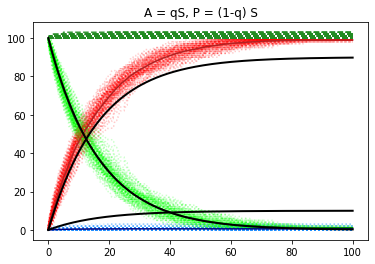

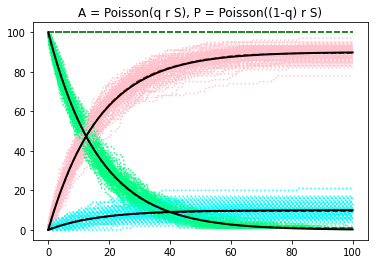

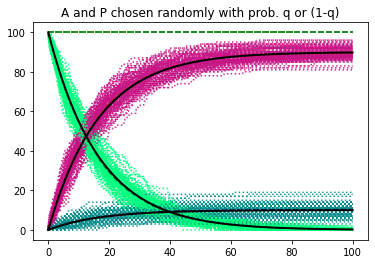

In [23]:
q=1/10
tf    = 100
avg_S = np.zeros(int(tf/dt)+1)
avg_A = np.zeros(int(tf/dt)+1)
avg_P = np.zeros(int(tf/dt)+1)
avg_t = np.zeros(int(tf/dt)+1)

plt.title("A = qS, P = (1-q) S")

for i in range(0,100):
    pop = np.zeros((n_pop,person_attr),int)          # Empty population
    link_weight = np.zeros(n_pop,float)              # Array for link weights
    n_per_location=np.zeros((n_loc,len(labels)),float) # Array to hold total number of individuals per state 
    createPop(0)
    
    s=time.time()
    t_a,S,A,P=T1(tf)
    e=time.time()
    
#     print("Time for T1",e-s)

    plt.plot(t_a,S,ls='dotted',color='lime',alpha=0.2)
    plt.plot(t_a,A,ls='dotted',color='dodgerblue',alpha=0.2)
    plt.plot(t_a,P,ls='dotted',color='r',alpha=0.2)
    
    plt.plot(t_a,S+A+P,ls='--',color='forestgreen',alpha=0.9)

    avg_S += S
    avg_A += A
    avg_P += P
    avg_t += t_a

avg_S = avg_S/100
avg_A = avg_A/100
avg_P = avg_P/100
avg_t = avg_t/100

plt.plot(avg_t,avg_S,color='green')
plt.plot(avg_t,avg_A,color='navy')
plt.plot(avg_t,avg_P,color='firebrick')

plt.plot(avg_t, 100*np.exp(-rate[0]*avg_t),color='black',lw=2)
plt.plot(avg_t, q*100*(1-np.exp(-rate[0]*avg_t)),color='black',lw=2)
plt.plot(avg_t, (1-q)*100*(1-np.exp(-rate[0]*avg_t)),color='black',lw=2)

plt.show()
####################

tf    = 100
avg_S = np.zeros(int(tf/dt)+1)
avg_A = np.zeros(int(tf/dt)+1)
avg_P = np.zeros(int(tf/dt)+1)
avg_t = np.zeros(int(tf/dt)+1)

plt.title("A = Poisson(q r S), P = Poisson((1-q) r S)")

for i in range(0,100):
    pop = np.zeros((n_pop,person_attr),int)          # Empty population
    link_weight = np.zeros(n_pop,float)              # Array for link weights
    n_per_location=np.zeros((n_loc,len(labels)),int) # Array to hold total number of individuals per state 
    createPop(0)
    
    s=time.time()
    t_a,S,A,P=T2(tf)
    e=time.time()
    
#     print("Time for T2",e-s)
    
    plt.plot(t_a,S,ls='dotted',color='springgreen',alpha=0.9)
    plt.plot(t_a,A,ls='dotted',color='cyan',alpha=0.9)
    plt.plot(t_a,P,ls='dotted',color='pink',alpha=0.9)
    
    plt.plot(t_a,S+A+P,ls='--',color='forestgreen',alpha=0.9)
    
    avg_S += S
    avg_A += A
    avg_P += P
    avg_t += t_a

avg_S = avg_S/100
avg_A = avg_A/100
avg_P = avg_P/100
avg_t = avg_t/100

plt.plot(avg_t,avg_S,'--',color='green')
plt.plot(avg_t,avg_A,'--',color='navy')
plt.plot(avg_t,avg_P,'--',color='firebrick')

plt.plot(avg_t, 100*np.exp(-rate[0]*avg_t),color='black',lw=2)
plt.plot(avg_t, q*100*(1-np.exp(-rate[0]*avg_t)),color='black',lw=2)
plt.plot(avg_t, (1-q)*100*(1-np.exp(-rate[0]*avg_t)),color='black',lw=2)

plt.show()


########################


tf    = 100
avg_S = np.zeros(int(tf/dt)+1)
avg_A = np.zeros(int(tf/dt)+1)
avg_P = np.zeros(int(tf/dt)+1)
avg_t = np.zeros(int(tf/dt)+1)

plt.title("A and P chosen randomly with prob. q or (1-q)")

for i in range(0,100):
    pop = np.zeros((n_pop,person_attr),int)          # Empty population
    link_weight = np.zeros(n_pop,float)              # Array for link weights
    n_per_location=np.zeros((n_loc,len(labels)),int) # Array to hold total number of individuals per state 
    createPop(0)
    
    s = time.time()
    t_a,S,A,P=T3(tf)
    e = time.time()
    
#     print("Time for T3",e-s)
    
    plt.plot(t_a,S,ls='dotted',color='springgreen',alpha=0.9)
    plt.plot(t_a,A,ls='dotted',color='darkcyan',alpha=0.9)
    plt.plot(t_a,P,ls='dotted',color='mediumvioletred',alpha=0.9)
    
    plt.plot(t_a,S+A+P,ls='--',color='forestgreen',alpha=0.9)
    
    avg_S += S
    avg_A += A
    avg_P += P
    avg_t += t_a

avg_S = avg_S/100
avg_A = avg_A/100
avg_P = avg_P/100
avg_t = avg_t/100

plt.plot(avg_t,avg_S,'--',color='green')
plt.plot(avg_t,avg_A,'--',color='navy')
plt.plot(avg_t,avg_P,'--',color='firebrick')

plt.plot(avg_t, 100*np.exp(-rate[0]*avg_t),color='black',lw=2)
plt.plot(avg_t, q*100*(1-np.exp(-rate[0]*avg_t)),color='black',lw=2)
plt.plot(avg_t, (1-q)*100*(1-np.exp(-rate[0]*avg_t)),color='black',lw=2)

plt.show()

In [24]:
np.round(0.3)

0.0